# Astronomical object detection with the Max-Tree

This notebook demonstrates how to use the Max-Tree for object detection in astronomical images. 
The method is described in:

> Teeninga, P., Moschini, U., Trager, and  Wilkinson, Michael H.F. (2016). [Statistical attribute filtering to detect faint extended astronomical sources](https://www.degruyter.com/downloadpdf/j/mathm.2016.1.issue-1/mathm-2016-0006/mathm-2016-0006.pdf). Mathematical Morphology - Theory and Applications, 1(1) doi:10.1515/mathm-2016-0006

It uses statistical significance tests to separate faint extented sources from the background.

The method works in 5 steps:

 1. Estimate noise and background
 2. Construct a Max-Tree
 3. Extract significant regions from the Max-Tree
 4. Select objects from significant nodes
 5. Select the representative isophote for each object

## 0. Preparation

In [1]:
%%capture
!pip install higra

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import higra as hg
from astropy.io import fits
from skimage.transform import rescale

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

try:
    from utils import * # imshow, locate_resource, saturate_max
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())

shape: (512, 512)


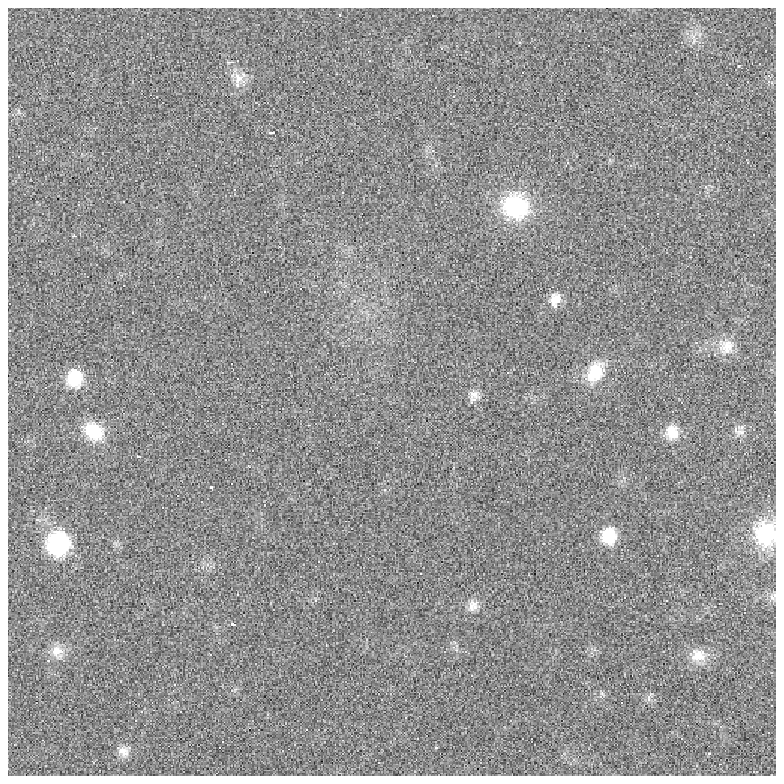

In [3]:
hdulist =  fits.open(locate_resource("img1-12.fits"))
hdu = hdulist[0]
im = hdu.data
print("shape:", im.shape)
imshow(saturate_max(im), cmap="gray");

## 1. Estimate noise and background

Noise, background (and gain) are estimated by searching for *empty* tiles in the image. A tile is considered as empty if the distribution of pixels inside the tile is Gaussian and if it has vertical and horizontal symetry (distribution of pixels are similar on each side).  

In [4]:
def estimate_background(im, rejection_rate=0.7, tile_size=32, show_tiles=False):
    from scipy.stats import normaltest, ttest_ind
    tile_size_D2 = tile_size // 2
    
    # split image in tiles
    tiles = get_tile_images(im, width=tile_size, height=tile_size)
    tiles = np.reshape(tiles, (-1, tile_size, tile_size))
    ntiles = tiles.shape[0]
    
    # normal distribution test on the whole tiles
    alpha1 = 1 - (1 - rejection_rate) ** 0.5
    _, p_val = normaltest(tiles.reshape((-1, tile_size * tile_size)), axis=1)

    # test if the distribution on the two halves of the tiles are the same
    alpha2 = 1 - (1 - rejection_rate) ** 0.25
    # vertical split
    _, p_val1 = ttest_ind(tiles[:, :tile_size_D2, :].reshape((ntiles, -1)), tiles[:, tile_size_D2:, :].reshape((ntiles, -1)), axis=1)
    # horizontal split
    _, p_val2 = ttest_ind(tiles[:, :, :tile_size_D2].reshape((ntiles, -1)), tiles[:, :, tile_size_D2:].reshape((ntiles, -1)), axis=1)
    
    # a tile is background if it passes the three tests
    ok_tiles = np.logical_and(p_val > alpha1, np.logical_and(p_val1 > alpha2, p_val2 > alpha2))
    tiles = tiles[ok_tiles, ...]

    if len(tiles) == 0:
        raise Exception("Cannot detect background, try decreasing the rejection rate or the tile size.")
        
    if show_tiles:
        print("Tiles selected for background estimation")
        imshow(np.hstack(tiles), cmap="gray")
    
    tiles = np.ravel(tiles)
   
    background_mean = np.mean(tiles)
    background_var = np.var(tiles)
    minimum = np.amin(np.ravel(im))
    gain = (background_mean - minimum) / background_var
    
    return np.mean(tiles), np.var(tiles), gain
    

Tiles selected for background estimation


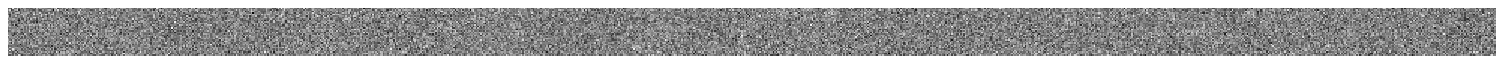

Mean: 779.1153 Variance: 276.2489 Gain: 0.24890423


In [5]:
background_mean, background_var, gain = estimate_background(im, rejection_rate=0.7, show_tiles=True)
print("Mean:", background_mean, "Variance:", background_var, "Gain:", gain)

## 2. Construct a Max-Tree

The image is first preprocessed with the result of the background estimation: the background is substracted and negative values are clipped at zero. Then the Max-Tree is built on a 4 adjacency graph.

In [6]:
im_normalized = im - background_mean
im_normalized = np.clip(im_normalized, a_min=0, a_max=None)

graph = hg.get_4_adjacency_graph(im_normalized.shape)
tree, altitudes = hg.component_tree_max_tree(graph, im_normalized)

## 3. Extract significant regions from the Max-Tree

Significant nodes are identified thanks to their power, i.e. the total squared flux in the node. Formaly, the power of a node $n$ is defined as:

$$P(n) = \sum_{x\in n} \big(image(x)-altitude(parent(n))\big)^2$$
    
The power of the node $n$ is then normalized by the local estimated noise, accounting for the Gaussian and Poisson noise, and defined as:

$$\sigma^2(n) = background\_var + \frac{altitude(parent(n))}{gain}$$

A $\chi^2$ test relating the estimated normalized power of a node $n$ with its size $area(n)$ is finally used to identify significant nodes.

In [7]:
def attribute_power(tree, altitudes, image):
    # power is computed using the following formula:
    # P(n) = sum_x(image(x)²) - 2*altitude(parent(n))*sum_x(image(x)) + area(n)*altitude(parent(n))²
    area = hg.attribute_area(tree)
    sum_vals = hg.accumulate_sequential(tree, image, hg.Accumulators.sum)
    sum_vals2 = hg.accumulate_sequential(tree, image * image, hg.Accumulators.sum)
    return sum_vals2 + area * altitudes[tree.parents()]**2 - 2 * altitudes[tree.parents()] * sum_vals

def attribute_statistical_significance(tree, altitudes, image, alpha, background_var, gain):
    from scipy.stats import chi2
    
    area = hg.attribute_area(tree)
    power = attribute_power(tree, altitudes, image)
    power /= (background_var + altitudes[tree.parents()] / gain)
   
    significant_nodes = power > chi2.ppf(alpha, area) # inverse cdf
    significant_nodes[:tree.num_leaves()] = False
    return significant_nodes

In [8]:
significant_nodes = attribute_statistical_significance(tree, altitudes, im_normalized, 1-1e-6, background_var, gain)

## 4. Select objects from significant nodes

A single object will generally be composed of several significant nodes. The aim of this step is to keep only the largest signifcant node representing an object. 

First all non significant nodes are removed. Then for each node, we define the main branch recusively as the largest child from this node. The final set of objects is composed of the largest (root) element of each main branch.  

In [9]:
def attribute_main_branch(tree):
    # True is a node is not the root of a main branch
    area = hg.attribute_area(tree)
    largest_child = hg.accumulate_parallel(tree, area, hg.Accumulators.argmax)
    child_number = hg.attribute_child_number(tree)
    return child_number == largest_child[tree.parents()]

def select_objects(tree, altitudes, significant_nodes):
    filtered_tree, node_map = hg.simplify_tree(tree, np.logical_not(significant_nodes))
    
    main_branch = attribute_main_branch(filtered_tree)

    # special case for the root
    if not significant_nodes[tree.root()]:
        root_children = filtered_tree.children(filtered_tree.root())
        main_branch[root_children] = False
        
    res = np.zeros(tree.num_vertices(), dtype=np.bool)
    res[node_map] = np.logical_not(main_branch)
    return res

In [10]:
objs = select_objects(tree, altitudes, significant_nodes)

## 5. Select the representative isophote for each object

The node selected in the fourth step often overestimate the size of the object. The aim of this last step is select an isophote slightly brighter than the one the represented by the selected node. For a given node $n$, the target isophote is defined as:

$$target\_altitude(n) =  altitude(n) + \lambda*\sigma(n),$$

where $\sigma(n)$ is the local estimation of the noise (see cells above).
The operation is called *move_up* because it consists in climbing the main branch until the desired isophote is found.

In [11]:
def move_up(tree, altitudes, objects, alambda, background_var, gain):
    # true if a node is in the main branch of its parent
    main_branch = attribute_main_branch(tree)
    
    # index of the closest object ancestor in the main branch, itself otherwise
    closest_object_ancestor = hg.propagate_sequential(
        tree, 
        np.arange(tree.num_vertices()), 
        np.logical_and(main_branch, np.logical_not(objects)))
    
    # objects should be move up in the main branch to their target altitude
    target_altitudes = altitudes.copy()
    object_indexes, = np.nonzero(objects)
    local_noise = np.sqrt(background_var + altitudes[tree.parent(object_indexes)] / gain)
    target_altitudes[object_indexes] = altitudes[object_indexes] + alambda * local_noise
    
    # target altitude associated to the closest object anacestor in the main branch, self altitude otherwise
    target_altitudes = target_altitudes[closest_object_ancestor]
    # a move is valid if the target altitude of the closest object ancestor in the main branch is lower than the
    # the curent altitude and if the closest object is a real object
    valid_moves = np.logical_and(altitudes >= target_altitudes, objects[closest_object_ancestor])
    
    parent_closest_object_ancestor = closest_object_ancestor[tree.parents()]
    parent_not_valid_moves = np.logical_not(valid_moves[tree.parents()])
    # a new object is a node n such that (valid_move(n) && (!valid_move(parent(n)) || closest(n) != closest(parent(n))))
    new_objects = np.logical_and(
        valid_moves, 
        np.logical_or(
            parent_not_valid_moves, 
            parent_closest_object_ancestor != closest_object_ancestor))
    return new_objects

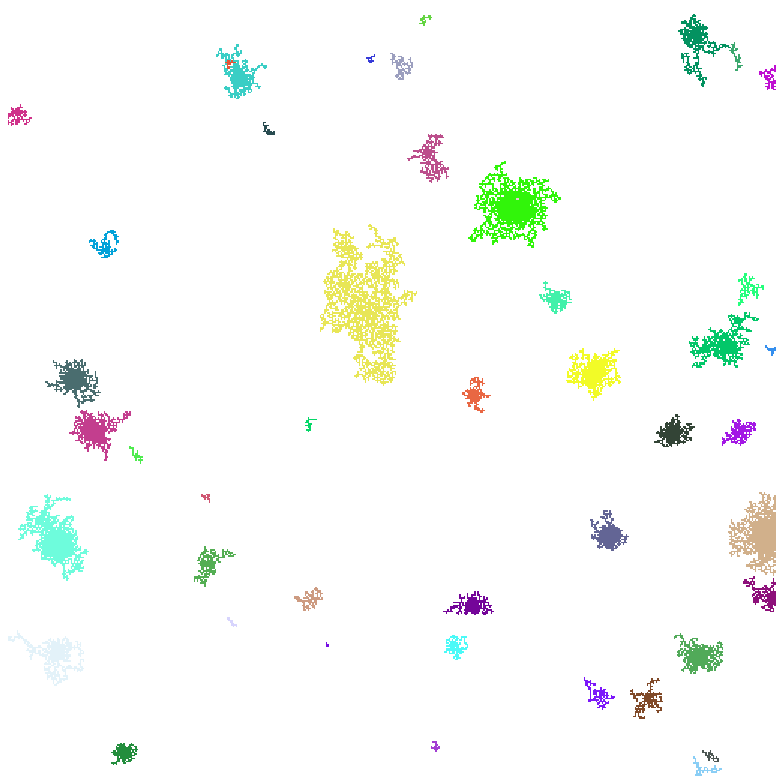

In [12]:
nobjs = move_up(tree, altitudes, objs, 0.1, background_var, gain)     

# construct final segmentation with random colors as labels
colors = np.random.randint(0, 256, (tree.num_vertices(), 3), dtype=np.uint8)
colors[tree.root(),:] = 255
seg = hg.reconstruct_leaf_data(tree, colors, np.logical_not(nobjs))
imshow(seg);

## Putting all together

In [13]:
def max_tree_objects(image):
    # 1.
    background_mean, background_var, gain = estimate_background(im, rejection_rate=0.7)
    
    # 2.
    im_normalized = im - background_mean
    im_normalized = np.clip(im_normalized, a_min=0, a_max=None)

    graph = hg.get_4_adjacency_graph(im_normalized.shape)
    tree, altitudes = hg.component_tree_max_tree(graph, im_normalized)

    # 3.
    significant_nodes = attribute_statistical_significance(tree, altitudes, im_normalized, 1-1e-6, background_var, gain)
    
    # 4.
    objs = select_objects(tree, altitudes, significant_nodes)
    
    # 5.
    nobjs = move_up(tree, altitudes, objs, 0.1, background_var, gain)
    
    np.random.seed(1)
    colors = np.random.randint(0, 256, (tree.num_vertices(), 3), dtype=np.uint8)
    colors[tree.root(),:] = 255
    return hg.reconstruct_leaf_data(tree, colors, np.logical_not(nobjs))

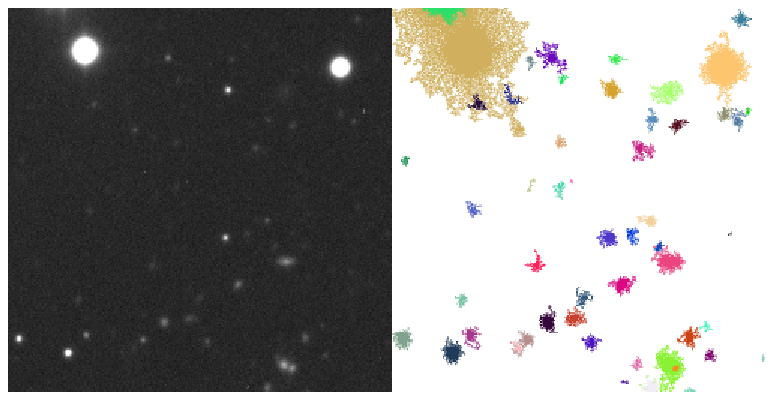

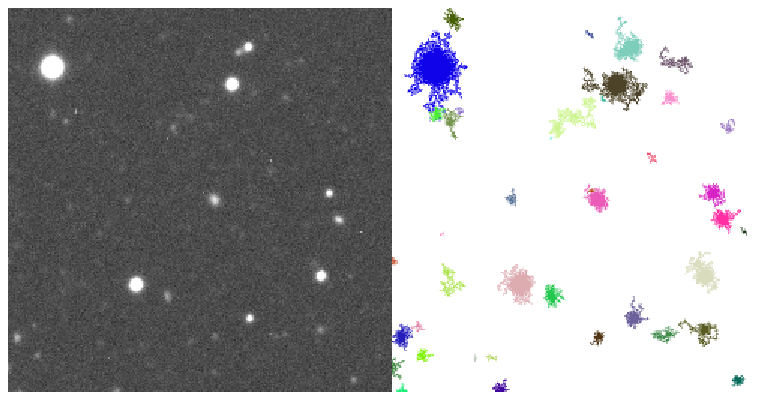

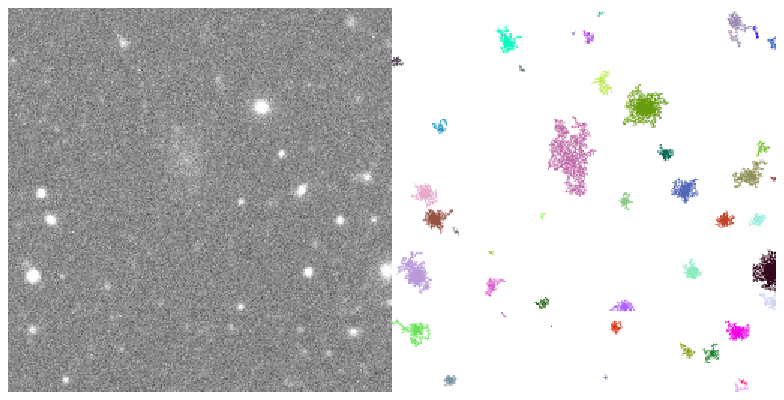

In [15]:
for im_file in ["img1-10.fits", "img1-11.fits", "img1-12.fits"]:
    scale = 0.5
    hdulist =  fits.open(locate_resource(im_file))
    im = hdulist[0].data
    im_disp = np.dstack([rescale(saturate_max(im), scale, anti_aliasing=False)] * 3)

    seg = max_tree_objects(im)
    seg_disp = rescale(seg, scale, anti_aliasing=False, multichannel=True) 

    imshow(np.hstack((im_disp, seg_disp)))
    